In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 100
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-18 13:56:15.095909: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-18 13:56:15.109908: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feef40eeab0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-18 13:56:15.109923: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
def calculate_term(e, c0, c1):
  a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
  b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
  return K.dot(K.transpose(a), b)

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
      p_loss += calculate_term(e, c0[i], c1[i])

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [12]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')

In [13]:
model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
          y=None,
          validation_data=([np.array(x_train_reshape)[limit:2*limit], y_train[limit:2*limit]], None),
          batch_size=batch_size,
          epochs=epochs)

Train on 4096 samples, validate on 4096 samples
Epoch 1/100
4096/4096 [==============================] - 19s 5ms/sample - loss: 1.8563 - acc: 0.9249 - val_loss: 0.9769 - val_acc: 0.9616
Epoch 2/100
4096/4096 [==============================] - 15s 4ms/sample - loss: 0.7075 - acc: 0.9755 - val_loss: 0.6076 - val_acc: 0.9794
Epoch 3/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.4875 - acc: 0.9850 - val_loss: 0.5016 - val_acc: 0.9832
Epoch 4/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.3828 - acc: 0.9893 - val_loss: 0.4262 - val_acc: 0.9858
Epoch 5/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.3136 - acc: 0.9921 - val_loss: 0.4000 - val_acc: 0.9859
Epoch 6/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.2707 - acc: 0.9937 - val_loss: 0.3697 - val_acc: 0.9869
Epoch 7/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.2245 - acc: 0.9957 - val_loss: 0.3471 - va

4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0381 - acc: 1.0000 - val_loss: 0.4899 - val_acc: 0.9842
Epoch 60/100
4096/4096 [==============================] - 13s 3ms/sample - loss: 0.0378 - acc: 0.9999 - val_loss: 0.4966 - val_acc: 0.9843
Epoch 61/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0397 - acc: 0.9999 - val_loss: 0.4859 - val_acc: 0.9843
Epoch 62/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0389 - acc: 1.0000 - val_loss: 0.5031 - val_acc: 0.9833
Epoch 63/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0390 - acc: 0.9999 - val_loss: 0.4907 - val_acc: 0.9846
Epoch 64/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0373 - acc: 0.9999 - val_loss: 0.5592 - val_acc: 0.9838
Epoch 65/100
4096/4096 [==============================] - 14s 3ms/sample - loss: 0.0369 - acc: 0.9999 - val_loss: 0.5193 - val_acc: 0.9839
Epoch 66/100
4096/4096 [================

### calculate test set accuracy

In [14]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.98093


### calculate activations across the training set

In [15]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [16]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 956.39it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


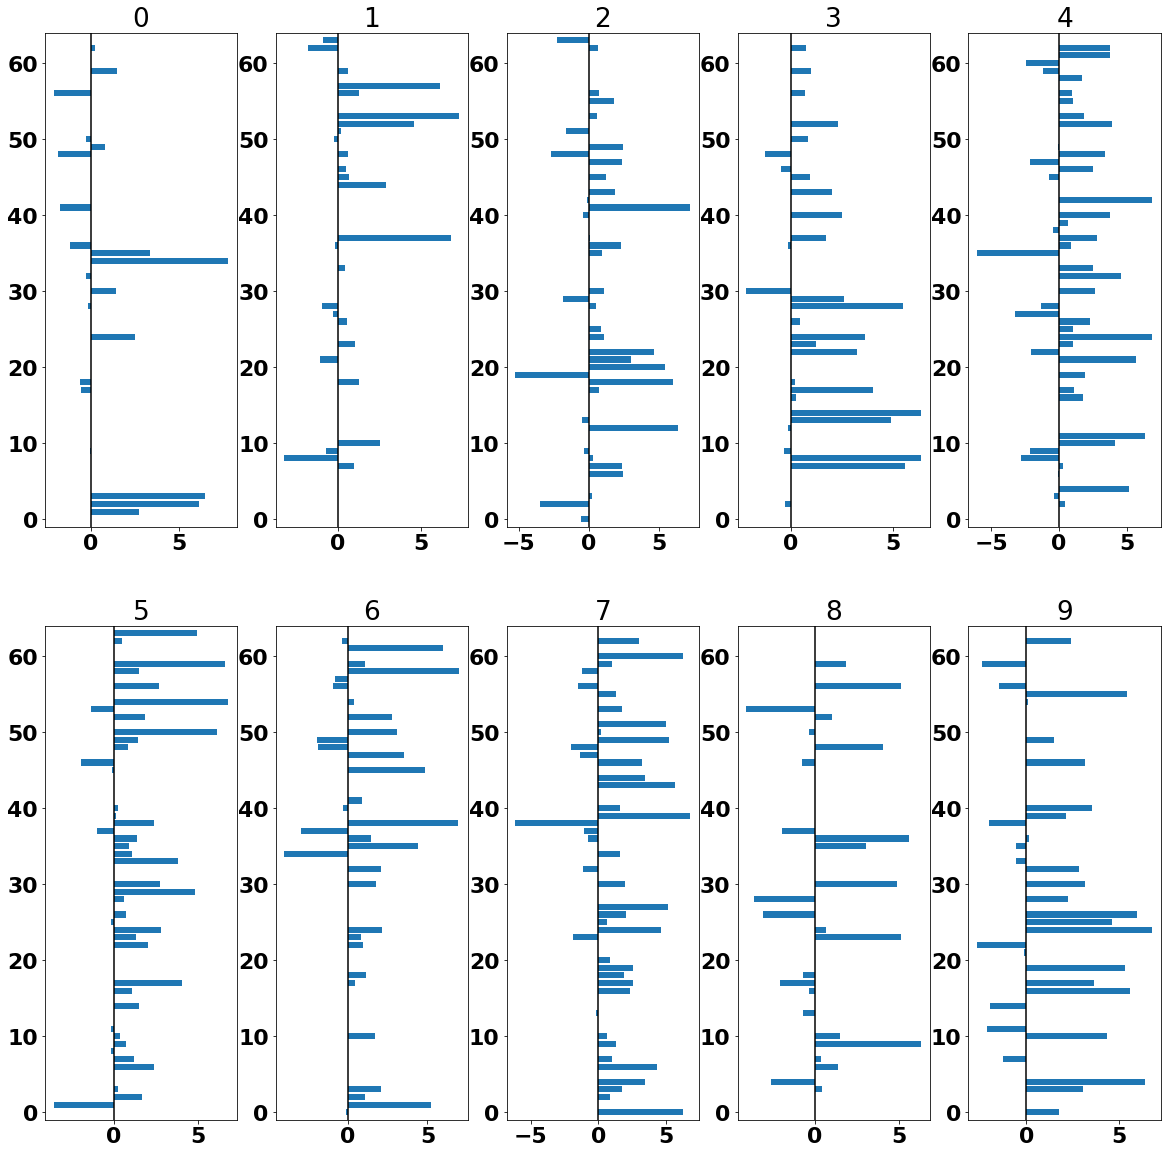

In [17]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))

### calculate activations across the test set

In [18]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5617.08it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


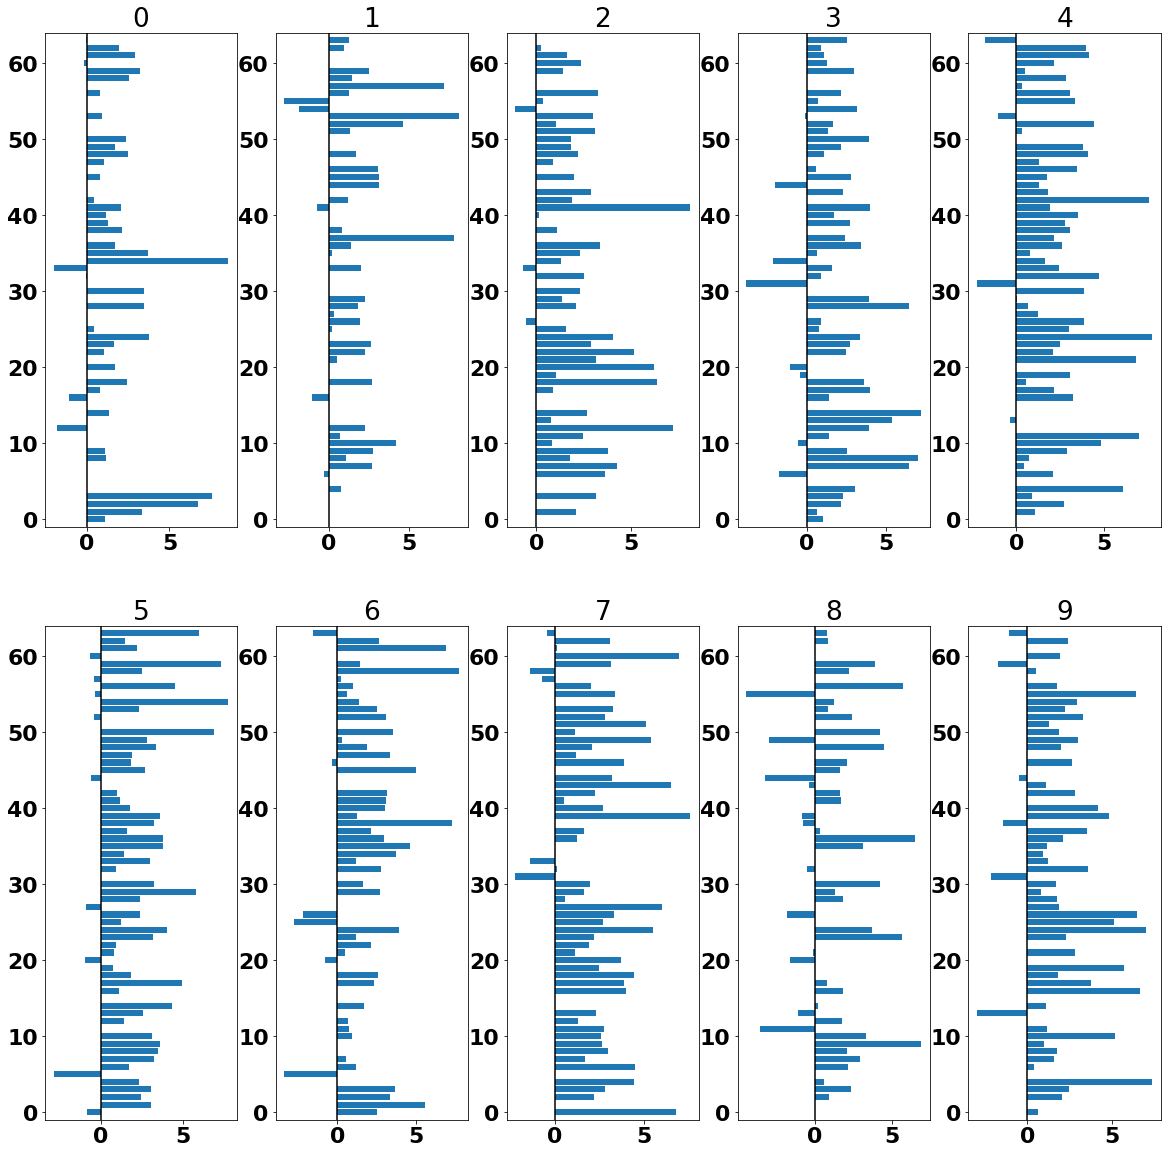

In [19]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class_test[k])))

### measure degree of polysemantism across training set activations

In [20]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
  a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
  b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
  sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.042801879063871534


### measure degree of polysemantism across test set activations

In [21]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
  a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
  b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
  sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

0.05457784126305746


### visualise hidden neurons

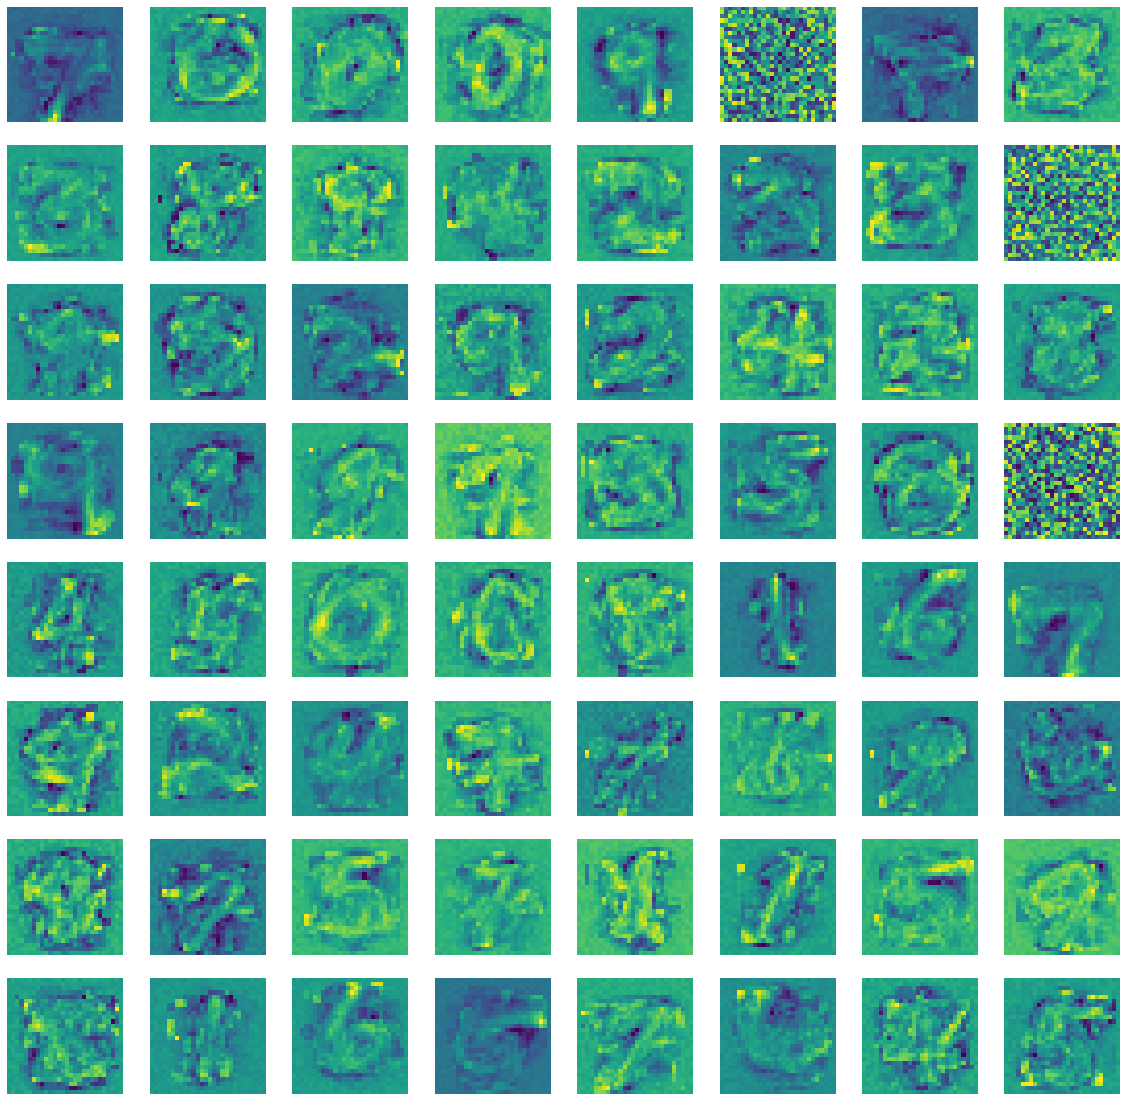

In [22]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
  x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
  ax = fig.add_subplot(dim,dim,j+1)
  ax.imshow(x_j.reshape((28,28)))
  plt.axis('off')
plt.show()